## Library Imports:

In [1]:
import pandas as pd

# Step 1: Collect Neighborhood Data for the City Toronto

## Scraping Table from Wiki

In [2]:
# link to wiki:
link = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
# Loading data and pre-processing
postal_df = pd.read_html(link)[0]
postal_df = postal_df[postal_df['Borough'] != 'Not assigned']
postal_df = postal_df.reset_index().drop('index', axis = 1)
# lambda function to replace
replace = lambda s : s.replace(' /', ',')
postal_df['Neighborhood'] = postal_df['Neighborhood'].apply(replace)
postal_df.head()

,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


## Loading Co-ordinates from csv file

In [3]:
geo_df = pd.read_csv('Geospatial_Coordinates.csv')
geo_df.rename(columns = {'Postal Code' : 'Postal code'}, inplace = True)
geo_df.head()

,Postal code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


## Merge the Dataframes:

In [5]:
to_data = postal_df.merge(geo_df, left_on = 'Postal code', right_on = 'Postal code')
to_data.head(10)

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


# Step 2: Collecting Venue Data from Foursquare API:

## More Library Imports

In [7]:
import numpy as np
import requests

## Define Foursquare API Credentials:

In [6]:
CLIENT_ID = 'T5PXJE5TAI2JDSTEJDY2TQR2EQRML2AHDEBBRN0NC2LWBYYR' # your Foursquare ID
CLIENT_SECRET = '1TFUQOLNAGXPYILNGZ3L3O3GBBTNVHAQUCHRCRZTSU1TFFMM' # your Foursquare Secret
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: T5PXJE5TAI2JDSTEJDY2TQR2EQRML2AHDEBBRN0NC2LWBYYR
CLIENT_SECRET:1TFUQOLNAGXPYILNGZ3L3O3GBBTNVHAQUCHRCRZTSU1TFFMM


## Function to get Nearby Venues:

In [8]:
def getNearbyVenues(names, latitudes, longitudes, LIMIT = 100, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Request for Nearby Venues from Foursquare API and store them into a dataframe:

In [10]:
to_venues = getNearbyVenues(names=to_data['Neighborhood'],
                                   latitudes=to_data['Latitude'],
                                   longitudes=to_data['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview
The Danforth West, Ri

In [11]:
to_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [12]:
to_venues.shape

(2151, 7)

# Step 3: Data Analysis

In [27]:
# No. of unique cateories
to_venues['Venue Category'].value_counts().head(20)

Coffee Shop             185
Café                    100
Restaurant               66
Park                     50
Pizza Place              48
Italian Restaurant       47
Hotel                    43
Japanese Restaurant      42
Sandwich Place           41
Bakery                   38
Clothing Store           36
Gym                      34
Bar                      32
Fast Food Restaurant     29
Sushi Restaurant         29
American Restaurant      29
Pub                      27
Bank                     26
Grocery Store            25
Breakfast Spot           24
Name: Venue Category, dtype: int64

In [14]:
# lambda function to check for restaurant
check_rest = lambda s : 'Restaurant' in s

In [15]:
# dataframe only contains restaurant
rest_df = to_venues[to_venues['Venue Category'].apply(check_rest)]
rest_df.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
5,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant
13,"Regent Park, Harbourfront",43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
29,"Regent Park, Harbourfront",43.654260,-79.360636,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant
43,"Regent Park, Harbourfront",43.654260,-79.360636,El Catrin,43.650601,-79.358920,Mexican Restaurant


In [16]:
rest_df.shape

(487, 7)

In [21]:
# Create a new Column Containing Restaurant Count:
to_venues['Restaurant'] = to_venues['Venue Category'].apply(check_rest)*1
to_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Restaurant
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park,0
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop,0
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena,0
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop,0
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant,1


## dataframe showing the count of restaurants grouped by Neighborhood

In [22]:
rest_counts = to_venues.groupby('Neighborhood')['Restaurant'].sum()
rest_counts = pd.DataFrame(rest_counts).reset_index()
rest_counts.head()

,Neighborhood,Restaurant
0,Agincourt,1
1,"Alderwood, Long Branch",0
2,"Bathurst Manor, Wilson Heights, Downsview North",3
3,Bayview Village,2
4,"Bedford Park, Lawrence Manor East",11


## Showing the Locations with Most Restaurants

In [43]:
rest_counts.sort_values(by = 'Restaurant', ascending = False).head(10)

,Neighborhood,Latitude,Longitude,Restaurant
43,"Commerce Court, Victoria Hotel",43.648198,-79.379817,30
87,"First Canadian Place, Underground city",43.648429,-79.382280,30
89,Church and Wellesley,43.665860,-79.383160,26
39,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,26
27,"Richmond, Adelaide, King",43.650571,-79.384568,24
8,"Garden District, Ryerson",43.657162,-79.378937,24
83,Stn A PO Boxes,43.646435,-79.374846,21
12,St. James Town,43.651494,-79.375418,21
21,Central Bay Street,43.657952,-79.387383,19
34,"Little Portugal, Trinity",43.647927,-79.419750,16


So it might be suggested that these locations are good candidates for opening restaurants.

In [ ]:
# Take the locations
to_locs = to_venues[['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude']]
to_locs.drop_duplicates(subset='Neighborhood', keep="first", inplace = True)

In [26]:
to_locs.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,Parkwoods,43.753259,-79.329656
2,Victoria Village,43.725882,-79.315572
8,"Regent Park, Harbourfront",43.654260,-79.360636
56,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
73,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [25]:
# Add latitude and longitude to dataframe
rest_counts = pd.merge(to_locs, rest_counts)
rest_counts.rename(columns = {'Neighborhood Latitude': 'Latitude', 'Neighborhood Longitude': 'Longitude'}, inplace = True)
rest_counts.head()

,Neighborhood,Latitude,Longitude,Restaurant
0,Parkwoods,43.753259,-79.329656,0
1,Victoria Village,43.725882,-79.315572,2
2,"Regent Park, Harbourfront",43.654260,-79.360636,4
3,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1
4,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,6


# Step 4: Plot the Restaurants in a map to Visualize Hotspots:

## More Library Imports:

In [35]:
from geopy.geocoders import Nominatim
import folium
from folium import plugins

## Get Latitude & Longitude of Toronto:

In [33]:
address = 'Toronto, TO'

geolocator = Nominatim(user_agent="to_explorer")

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


## Plot the number of Restaurants in Map:

In [40]:
toronto_map = folium.Map(location = [latitude, longitude], zoom_start = 11)

In [41]:
# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(toronto_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(rest_counts.Latitude, rest_counts.Longitude, rest_counts.Restaurant):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        #popup=label,
    ).add_to(incidents)

# display map
toronto_map

So we can decide on the location with hotspots from the Plot. The **Yellow Zone** is more likely to host a Restaurant.

# Step 5: Data Preperation for Machine Learning Models

## One-hot Encoding of the Venues vs. 267 Categories

In [44]:
# one hot encoding
toronto_onehot = pd.get_dummies(to_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = to_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()

,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Group By Neighborhood and Sum

In [45]:
# Group by Neighborhood and Sum
toronto_grouped = toronto_onehot.groupby('Neighborhood').sum().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Alderwood, Long Branch",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,Bayview Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Bedford Park, Lawrence Manor East",0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## collect the top 5 occuring venues per neighborhood in a list

In [48]:
num_top_venues = 5
top_venues = []

for hood in toronto_grouped['Neighborhood']:
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    venues = temp.sort_values('freq', ascending = False).head(num_top_venues)['venue'].tolist()
    top_venues.extend(venues)

top_venues = np.unique(np.asarray(top_venues))
venues = pd.Series(top_venues)
venues.head()

0      Accessories Store
1         Airport Lounge
2        Airport Service
3       Airport Terminal
4    American Restaurant
dtype: object

## Filter Out restaurants from the venues

We filter out the columns containing any information about restaurants since we want to train a classifier to predict exactly the same.

In [52]:
# lambda function to filter out the not restaurants:
check_notrest = lambda s : not 'Restaurant' in s
features = venues[venues.apply(check_notrest)].tolist()
features.insert(0, 'Neighborhood')
features[0:10]

['Neighborhood',
 'Accessories Store',
 'Airport Lounge',
 'Airport Service',
 'Airport Terminal',
 'Aquarium',
 'Athletics & Sports',
 'Auto Garage',
 'Auto Workshop',
 'Bakery']

This part takes all the features. It will be used for the clustering model.

In [53]:
all_features = venues.tolist()
all_features.insert(0, 'Neighborhood')

# Step 6: Create a Machine Learning Classifier to predict the Likelihood of a Restaurant

## More Library Imports:

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_similarity_score, log_loss, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

## Dataframe with 108 Features

In [55]:
feat_df = toronto_grouped[features]
feat_df.head()

,Neighborhood,Accessories Store,Airport Lounge,Airport Service,Airport Terminal,Aquarium,Athletics & Sports,Auto Garage,Auto Workshop,Bakery,...,Smoke Shop,Soccer Field,Spa,Sporting Goods Shop,Swim School,Trail,Train Station,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Alderwood, Long Branch",0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bayview Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Bedford Park, Lawrence Manor East",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
rest_counts.head()

,Neighborhood,Latitude,Longitude,Restaurant
0,Parkwoods,43.753259,-79.329656,0
1,Victoria Village,43.725882,-79.315572,2
2,"Regent Park, Harbourfront",43.654260,-79.360636,4
3,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1
4,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,6


## Merge to create final dataframe

In [58]:
df = pd.merge(rest_counts, feat_df)
# move restaurant column to the back
rest = df.pop('Restaurant')
df['Restaurant'] = rest
df.head()

,Neighborhood,Latitude,Longitude,Accessories Store,Airport Lounge,Airport Service,Airport Terminal,Aquarium,Athletics & Sports,Auto Garage,...,Soccer Field,Spa,Sporting Goods Shop,Swim School,Trail,Train Station,Wings Joint,Women's Store,Yoga Studio,Restaurant
0,Parkwoods,43.753259,-79.329656,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Victoria Village,43.725882,-79.315572,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,"Regent Park, Harbourfront",43.654260,-79.360636,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,4
3,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
4,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6


## Correlation

## Positive Correlation:

In [66]:
# Taking correlation and using features with corr score > + 0.20
corr_values = pd.DataFrame(df.corr()['Restaurant']).reset_index()
corr_values.sort_values(by = 'Restaurant', ascending = False).head(10)

,index,Restaurant
110,Restaurant,1.000000
25,Café,0.832903
31,Coffee Shop,0.830975
67,Hotel,0.743790
54,Gastropub,0.719778
59,Gym,0.680451
17,Bookstore,0.676022
38,Deli / Bodega,0.667530
15,Beer Bar,0.654870
73,Lounge,0.572245


## Negative Correlation:

In [77]:
corr_values.sort_values(by = 'Restaurant', ascending = True).head(10)

,index,Restaurant
0,Latitude,-0.352364
24,Bus Line,-0.145087
69,Intersection,-0.140361
34,Construction & Landscaping,-0.125458
7,Athletics & Sports,-0.125264
94,Rental Car Location,-0.110904
90,Pool,-0.109486
77,Metro Station,-0.092145
66,Hockey Arena,-0.082418
2,Accessories Store,-0.082418


Negative correlation values are insignificant, so we can ignore them.

## Seaborn Regression Plots:

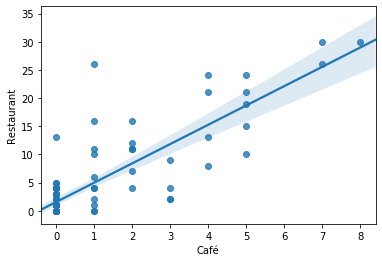

In [71]:
sns.regplot(data = df, x = 'Café', y = 'Restaurant')
plt.show()

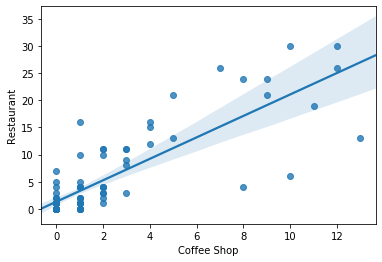

In [72]:
sns.regplot(data = df, x = 'Coffee Shop', y = 'Restaurant')
plt.show()

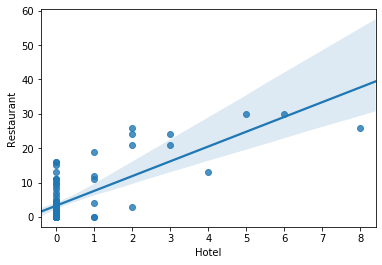

In [73]:
sns.regplot(data = df, x = 'Hotel', y = 'Restaurant')
plt.show()

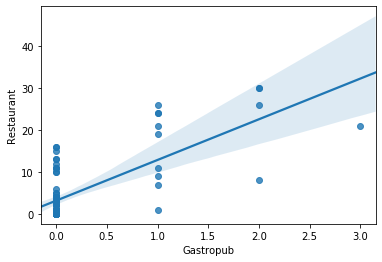

In [74]:
sns.regplot(data = df, x = 'Gastropub', y = 'Restaurant')
plt.show()

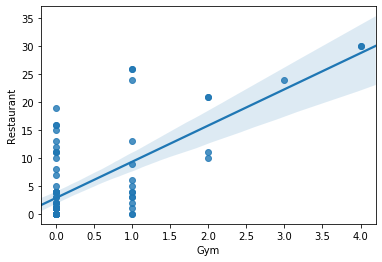

In [75]:
sns.regplot(data = df, x = 'Gym', y = 'Restaurant')
plt.show()

## Taking the important features: Having a +ve correlation value > 0.20

In [78]:
imp_features = corr_values[corr_values['Restaurant'] > 0.20]['index'].tolist()
# discarding the feature 'Restaurant', since it is our target
imp_features.remove('Restaurant')

## Taking Important Feature values for the Model:

In [79]:
X = df[imp_features].values
y = df['Restaurant'].values

In [80]:
print(X.shape)
print(y.shape)

(93, 37)
(93,)


## Data Normalization:

In [81]:
ss = StandardScaler()
ss.fit(X)
X = ss.fit_transform(X)

In [82]:
# Converting y into a binary feature 1 = Restaurant Exists, 0 = Does not exist
y = y.astype(np.bool)*1

## Train-Test Split:

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [163]:
model_lr = LogisticRegression()
model_knn = KNeighborsClassifier(n_neighbors = 5)
model_dt = DecisionTreeClassifier(max_depth = 5)
model_svc = SVC(kernel = 'rbf')

In [164]:
models = [model_lr, model_knn, model_dt, model_svc]
model_names = ['Logistic Regression', 'kNN', 'Decision Tree', 'SVM']

In [165]:
for model, model_name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    print('---------------')
    print(model_name)
    print('Training score: ' , model.score(X_train, y_train))
    print('Testing score: ', model.score(X_test, y_test))
    print('Jaccard index: ', jaccard_similarity_score(y_test, y_hat))
    print('Log loss: ' , log_loss(y_test, y_hat))
    print('f1 Score: ', f1_score(y_test, y_hat))

---------------
Logistic Regression
Training score:  0.8378378378378378
Testing score:  0.8421052631578947
Jaccard index:  0.8421052631578947
Log loss:  5.45349100972274
f1 Score:  0.88
---------------
kNN
Training score:  0.7837837837837838
Testing score:  0.6842105263157895
Jaccard index:  0.6842105263157895
Log loss:  10.907024103520753
f1 Score:  0.75
---------------
Decision Tree
Training score:  0.8648648648648649
Testing score:  0.7894736842105263
Jaccard index:  0.7894736842105263
Log loss:  7.271321346296986
f1 Score:  0.8333333333333333
---------------
SVM
Training score:  0.8108108108108109
Testing score:  0.7368421052631579
Jaccard index:  0.7368421052631579
Log loss:  9.089193766946508
f1 Score:  0.8


In [166]:
model_lr.predict(X_train)

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0])

In [168]:
model_lr.predict_proba(X_train)[:10]

array([[0.06491546, 0.93508454],
       [0.32281501, 0.67718499],
       [0.4199619 , 0.5800381 ],
       [0.67377743, 0.32622257],
       [0.00163898, 0.99836102],
       [0.01953327, 0.98046673],
       [0.78829366, 0.21170634],
       [0.03087613, 0.96912387],
       [0.1212558 , 0.8787442 ],
       [0.62416887, 0.37583113]])

The **logistic regression model** is performing well on the Test data. So we can use it to predict the probability of a location given the 37 features we taook.

# Step 7: Clustering

## More Library Imports:

In [169]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

## Preparing the data
Taking all the Features including those of restaurants for Clustering, since it is unsupervised.

In [178]:
all_feat_df = toronto_grouped[all_features]
rest_counts.rename(columns = {'Restaurant':'RestCnt'}, inplace = True)
df = pd.merge(rest_counts, all_feat_df)
rest = df.pop('RestCnt')
df['RestCnt'] = rest
df.head()

,Neighborhood,Latitude,Longitude,Accessories Store,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Asian Restaurant,...,Swim School,Thai Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Women's Store,Yoga Studio,RestCnt
0,Parkwoods,43.753259,-79.329656,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Victoria Village,43.725882,-79.315572,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,"Regent Park, Harbourfront",43.654260,-79.360636,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,4
3,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
4,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6


## Taking correlation and using features with corr score > + 0.20

In [179]:
corr_values = pd.DataFrame(df.corr()['RestCnt']).reset_index()
features = corr_values[corr_values['RestCnt'] > 0.20]['index'].tolist()
features.remove('RestCnt')

## Taking data values

In [180]:
X = df[features].values

In [193]:
X.shape

(93, 60)

## Normalizing:

In [181]:
ss = StandardScaler()
ss.fit(X)
X = ss.fit_transform(X)

## Clustering:

In [182]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 0, 2, 0, 2, 2, 2, 1, 2])

In [183]:
df.insert(3, 'Cluster', kmeans.labels_)
df.head()

,Neighborhood,Latitude,Longitude,Cluster,Accessories Store,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,...,Swim School,Thai Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Women's Store,Yoga Studio,RestCnt
0,Parkwoods,43.753259,-79.329656,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Victoria Village,43.725882,-79.315572,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,"Regent Park, Harbourfront",43.654260,-79.360636,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4
3,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
4,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6


## Create Cluster Map

In [184]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [188]:
df.groupby(by = 'Cluster').mean()

,Latitude,Longitude,Accessories Store,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Asian Restaurant,Athletics & Sports,...,Swim School,Thai Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Women's Store,Yoga Studio,RestCnt
Cluster,,,,,,,,,,,,,,,,,,,,,
0,43.679699,-79.387828,0.000000,0.000000,0.000000,0.000000,0.500000,0.0,0.285714,0.000000,...,0.000000,0.428571,0.071429,0.000000,0.428571,0.428571,0.000000,0.071429,0.714286,12.500000
1,43.657162,-79.378937,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,24.000000
2,43.711207,-79.395457,0.028571,0.028571,0.042857,0.028571,0.085714,0.0,0.028571,0.114286,...,0.014286,0.071429,0.057143,0.014286,0.014286,0.042857,0.014286,0.028571,0.042857,1.585714
3,43.647038,-79.381999,0.000000,0.000000,0.000000,0.000000,2.400000,1.0,1.400000,0.000000,...,0.000000,1.400000,0.000000,0.600000,1.200000,0.000000,0.000000,0.200000,0.000000,24.600000
4,43.647567,-79.374523,0.000000,0.000000,0.000000,0.000000,1.333333,0.0,0.333333,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.333333,18.000000


## Taking the mean number of Restaurants for Each Cluster:

In [192]:
df.groupby(by = 'Cluster').mean()['RestCnt']

Cluster
0    12.500000
1    24.000000
2     1.585714
3    24.600000
4    18.000000
Name: RestCnt, dtype: float64

**We can conclude that cluster 2 has a less chance of hosting a Restaurant. The other clusters have plenty chance.**

## Counting the number of entries per cluster:

In [190]:
df['Cluster'].value_counts()

2    70
0    14
3     5
4     3
1     1
Name: Cluster, dtype: int64

It is also seen that there are 70 neighborhoods in the cluster 2, so that is a substantial area, which we want to avoid. Which is the **Blue** Cluster